In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from tqdm import tqdm 
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from transformers import BertTokenizer
from torch.utils.data import Dataset

model_path = '../Model/sentiment_bert'
tokenizer = BertTokenizer.from_pretrained(model_path)

# Load original full datasets
train_df = pd.read_csv('../Dataset/train_preprocessed.csv')
val_df = pd.read_csv('../Dataset/val_preprocessed.csv')

# Optional: use a smaller shuffled subset of the data for faster tuning
USE_SUBSET = True

if USE_SUBSET:
    train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)[:3000]
    val_df = val_df.sample(frac=1, random_state=42).reset_index(drop=True)[:1000]

# Define custom dataset
class CustomDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.texts = df['Phrase'].tolist()
        self.labels = df['Sentiment'].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Build dataset from filtered DataFrame
train_dataset = CustomDataset(train_df, tokenizer)
val_dataset = CustomDataset(val_df, tokenizer)


In [4]:
def load_pretrained_bert_classifier(model_path, device):
    config = BertConfig.from_pretrained(model_path, output_hidden_states=True)
    model = BertForSequenceClassification.from_pretrained(model_path, config=config)
    model.to(device)
    return model

class RLPolicyNet(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=32, action_dim=6):
        super(RLPolicyNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.model(x)

In [5]:
from tqdm import tqdm
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    loop = tqdm(dataloader, desc="Training", leave=False)
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        loop.set_postfix(loss=loss.item())
    return total_loss / len(dataloader)

def evaluate(model, dataloader, device):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [6]:
import time
import gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Predefined hyperparameter combinations
action_table = {
    0: {"lr": 1e-5,  "opt": "Adam",  "batch_size": 64,  "dropout": 0.1},
    1: {"lr": 3e-5,  "opt": "Adam",  "batch_size": 32,  "dropout": 0.2},
    2: {"lr": 1e-4,  "opt": "AdamW", "batch_size": 64,  "dropout": 0.3},
    3: {"lr": 3e-5,  "opt": "AdamW", "batch_size": 32,  "dropout": 0.1},
    4: {"lr": 1e-5,  "opt": "SGD",   "batch_size": 64,  "dropout": 0.3},
    5: {"lr": 1e-4,  "opt": "SGD",   "batch_size": 32,  "dropout": 0.2}
}

# Initialize policy network and optimizer
policy_net = RLPolicyNet(input_dim=2, hidden_dim=32, action_dim=len(action_table)).to(device)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)

# Lists to record training logs
log_probs, rewards, accs = [], [], []
actions, lrs, opts, batch_sizes, dropouts = [], [], [], [], []

# Load base BERT model only once
base_model = load_pretrained_bert_classifier(model_path, device)

prev_acc = 0.0
num_rl_steps = 10
EPOCHS = 2

for step in range(num_rl_steps):
    step_start = time.time()

    # Generate state input and sample action from policy network
    state = torch.tensor([prev_acc, step / num_rl_steps], dtype=torch.float32).unsqueeze(0).to(device)
    probs = policy_net(state)
    dist = torch.distributions.Categorical(probs)
    action = dist.sample()
    log_probs.append(dist.log_prob(action))

    # Extract hyperparameters from action table
    config = action_table[action.item()]
    actions.append(action.item())
    lrs.append(config["lr"])
    opts.append(config["opt"])
    batch_sizes.append(config["batch_size"])
    dropouts.append(config["dropout"])

    # Copy the base model to avoid reloading from disk
    import copy
    model = copy.deepcopy(base_model)

    # Create optimizer based on selected type
    if config["opt"] == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    elif config["opt"] == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=config["lr"])
    elif config["opt"] == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=config["lr"])

    criterion = nn.CrossEntropyLoss()
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    # Train the model for the specified number of epochs
    for _ in range(EPOCHS):
        train_one_epoch(model, train_loader, optimizer, criterion, device)

    # Evaluate model performance and compute reward
    acc = evaluate(model, val_loader, device)
    reward = acc - prev_acc
    rewards.append(reward)
    accs.append(acc)
    prev_acc = acc

    # Free up GPU memory
    del model
    torch.cuda.empty_cache()
    gc.collect()

    # Print training summary for current step
    print(f"Step {step} | Opt: {config['opt']} | LR: {config['lr']} | BS: {config['batch_size']} | Dropout: {config['dropout']} | Acc: {acc:.4f} | Time: {(time.time() - step_start) / 60:.2f} min")


Step 0 | Opt: Adam | LR: 3e-05 | BS: 32 | Dropout: 0.2 | Acc: 0.5910 | Time: 7.40 min


Step 1 | Opt: Adam | LR: 1e-05 | BS: 64 | Dropout: 0.1 | Acc: 0.5960 | Time: 14.65 min


Step 2 | Opt: AdamW | LR: 0.0001 | BS: 64 | Dropout: 0.3 | Acc: 0.5990 | Time: 24.86 min


Step 3 | Opt: AdamW | LR: 0.0001 | BS: 64 | Dropout: 0.3 | Acc: 0.5730 | Time: 14.81 min


Step 4 | Opt: Adam | LR: 3e-05 | BS: 32 | Dropout: 0.2 | Acc: 0.5860 | Time: 11.55 min


Step 5 | Opt: AdamW | LR: 3e-05 | BS: 32 | Dropout: 0.1 | Acc: 0.6010 | Time: 6.22 min


Step 6 | Opt: Adam | LR: 3e-05 | BS: 32 | Dropout: 0.2 | Acc: 0.5870 | Time: 5.56 min


Step 7 | Opt: Adam | LR: 3e-05 | BS: 32 | Dropout: 0.2 | Acc: 0.6000 | Time: 7.11 min


Step 8 | Opt: Adam | LR: 3e-05 | BS: 32 | Dropout: 0.2 | Acc: 0.5700 | Time: 7.86 min


Step 9 | Opt: SGD | LR: 0.0001 | BS: 32 | Dropout: 0.2 | Acc: 0.6080 | Time: 4.80 min


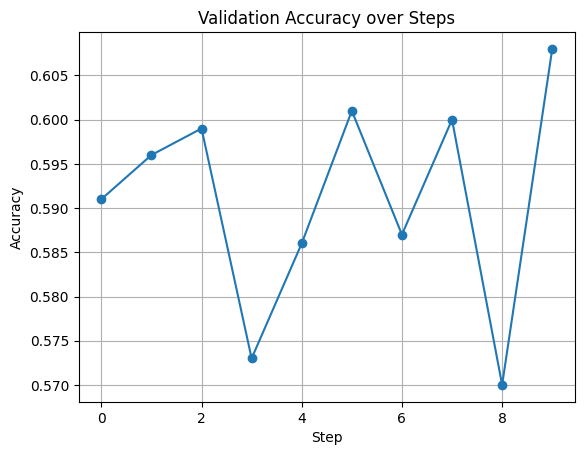

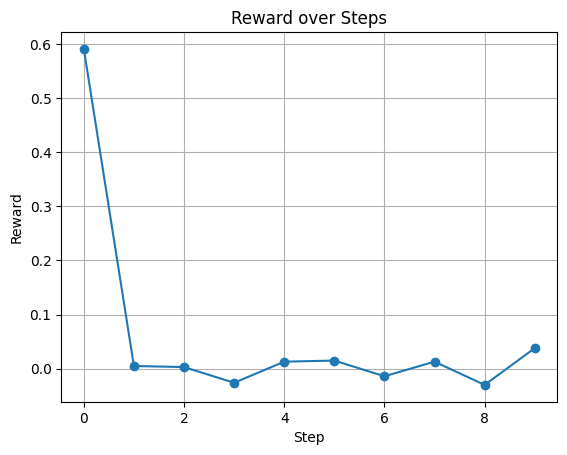

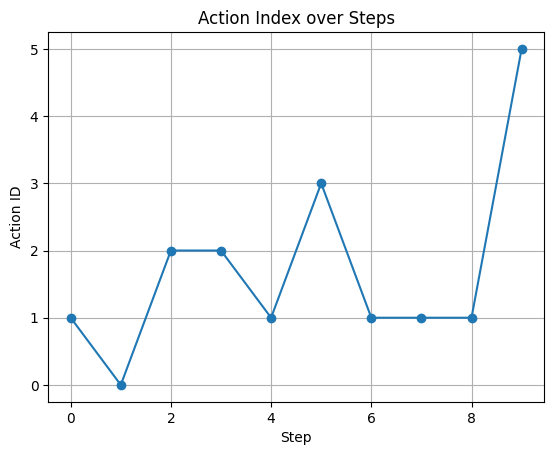

Best Configuration:
Step        : 9
Accuracy    : 0.6080
Optimizer   : SGD
LearningRate: 0.0001
BatchSize   : 32
Dropout     : 0.2


In [7]:
# Policy update (REINFORCE)
discounted_rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-6)
loss = -sum(log_prob * reward for log_prob, reward in zip(log_probs, discounted_rewards))
policy_optimizer.zero_grad()
loss.backward()
policy_optimizer.step()

# visualize curl
plt.plot(range(num_rl_steps), accs, marker='o')
plt.title("Validation Accuracy over Steps")
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

plt.plot(range(num_rl_steps), rewards, marker='o')
plt.title("Reward over Steps")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

plt.plot(range(num_rl_steps), actions, marker='o')
plt.title("Action Index over Steps")
plt.xlabel("Step")
plt.ylabel("Action ID")
plt.grid(True)
plt.show()

# best idx
best_idx = int(np.argmax(accs))
print("Best Configuration:")
print(f"Step        : {best_idx}")
print(f"Accuracy    : {accs[best_idx]:.4f}")
print(f"Optimizer   : {opts[best_idx]}")
print(f"LearningRate: {lrs[best_idx]}")
print(f"BatchSize   : {batch_sizes[best_idx]}")
print(f"Dropout     : {dropouts[best_idx]}")